# Background Information

When an analyst determines the price of a house, they need to consider many predictors, including location, size, and construction quality. Luckily, machine learning models exist to do the work for them. In this project, I trained and evaluated regression models to predict the prices of houses. I used a dataset from OpenIntro of 2930 houses in Ames, Iowa with 79 predictors. To download the dataset and read the predictor descriptions, [click here](https://www.openintro.org/data/index.php?data=ames). 

# Import Libraries and Data

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from matplotlib.patches import Rectangle

sns.set_theme()

In [51]:
# Use the Order column (unique identifier for each house) as the row index
houses_data = pd.read_csv('ames_houses_data.csv', index_col="Order")

train_data, test_data = train_test_split(houses_data, test_size=0.2, random_state=42)

print("Training dataset size: ", train_data.shape)
print("Test dataset size: ", test_data.shape)

Training dataset size:  (2344, 81)
Test dataset size:  (586, 81)


# Data Procesesing

## Removing categorical predictors

To simplify the analysis, I only used quantitative predictors.

In [52]:
houses_data = houses_data.select_dtypes(include="number")
# Manually remove categorical columns encoded with integers
houses_data.drop(columns=["MS.SubClass", "Mo.Sold", "PID"], inplace=True) 
houses_data_pred = houses_data.loc[:, houses_data.columns!="price"]
print(f"There are {len(houses_data_pred.columns)} predictors left:\n",
      list(houses_data_pred.columns), sep="")

There are 34 predictors left:
['area', 'Lot.Frontage', 'Lot.Area', 'Overall.Qual', 'Overall.Cond', 'Year.Built', 'Year.Remod.Add', 'Mas.Vnr.Area', 'BsmtFin.SF.1', 'BsmtFin.SF.2', 'Bsmt.Unf.SF', 'Total.Bsmt.SF', 'X1st.Flr.SF', 'X2nd.Flr.SF', 'Low.Qual.Fin.SF', 'Bsmt.Full.Bath', 'Bsmt.Half.Bath', 'Full.Bath', 'Half.Bath', 'Bedroom.AbvGr', 'Kitchen.AbvGr', 'TotRms.AbvGrd', 'Fireplaces', 'Garage.Yr.Blt', 'Garage.Cars', 'Garage.Area', 'Wood.Deck.SF', 'Open.Porch.SF', 'Enclosed.Porch', 'X3Ssn.Porch', 'Screen.Porch', 'Pool.Area', 'Misc.Val', 'Yr.Sold']


## Handling missing data

Regression models cannot be trained on data with missing values. Since model training works best with a lot of data, we cannot simply delete all the data points with missing values. Instead, we can replace missing data with a best guess based on other data in the dataset (data imputation). First, I will check which predictors in the dataset have missing values.

In [53]:
missing_data_count = houses_data.isnull().sum()
missing_data_percent = houses_data.isnull().sum() / len(houses_data) * 100
missing_data = pd.DataFrame({
    'No. of missing values': missing_data_count,
    'Percentage of values missing': missing_data_percent
})
missing_data = missing_data[missing_data.loc[:,'No. of missing values'] > 0]
missing_data.sort_values(by='Percentage of values missing', ascending=False, inplace=True)
print("The predictors with the most missing values:\n")
missing_data.head(3)

The predictors with the most missing values:



,No. of missing values,Percentage of values missing
Lot.Frontage,490,16.723549
Garage.Yr.Blt,159,5.426621
Mas.Vnr.Area,23,0.784983


Strategy for imputing the missing values:
- **Lot.Frontage**: The distance between the house and the front road. I will impute the missing values with the average value in the training dataset. It would be incorrect to use the average value in the entire dataset since only data in the training set can be used to train the models (data leakage). 
- **Garage.Yr.Blt**: The year the garage was built. Since it is highly correlated with **Year.Built** (r = 0.826, see the correlation map below), I will impute the missing values with the **Year.Built** values. 

For the remaining predictors, the number of missing values were small, so I simply deleted the houses with those missing values.

In [54]:
houses_data.loc[:,"Lot.Frontage"] = (houses_data.loc[:,"Lot.Frontage"].
                                     fillna(train_data.loc[:,"Lot.Frontage"].mean()))
houses_data.loc[:,"Garage.Yr.Blt"] = (houses_data.loc[:,"Garage.Yr.Blt"].
                                      fillna(houses_data.loc[:,"Year.Built"]))

# Drop all rows with missing values
train_data = houses_data[:len(train_data)].dropna()
test_data = houses_data[len(houses_data)-len(test_data):].dropna()
houses_data.dropna(inplace=True)

print("No. of missing values remaining is:", 
      sum(houses_data.isnull().sum()))
print("New training set size:", train_data.shape)
print("New test set size:", test_data.shape)

No. of missing values remaining is: 0
New training set size: (2322, 35)
New test set size: (582, 35)


# Exploratory Data Analysis

## Distribution of the target (house prices)

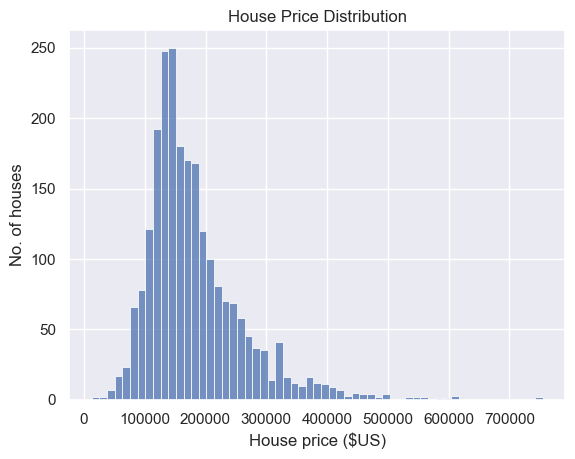

In [55]:
sns.histplot(train_data.loc[:,"price"])
plt.title("House Price Distribution")
plt.xlabel("House price ($US)")
plt.ylabel("No. of houses")
plt.show()

The distribution of house prices is positively skewed due to the presence of a few very expensive houses. 

## Correlations between variables

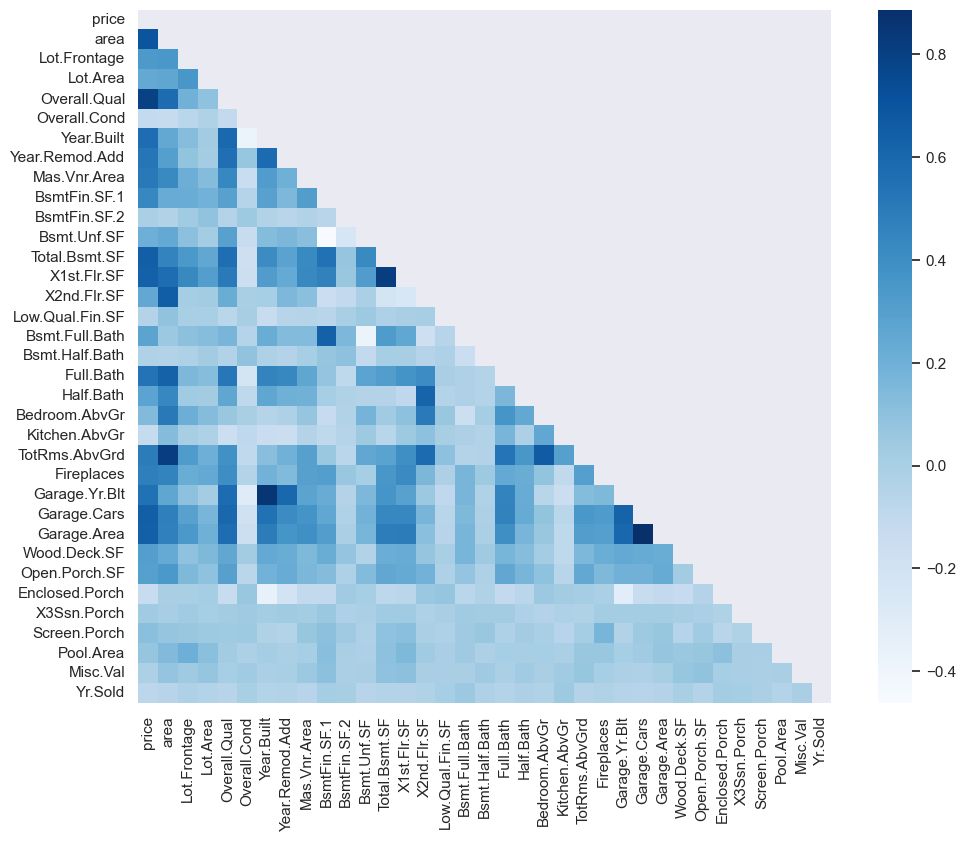

In [56]:
correlation_matrix = pd.concat([train_data]).corr()
lower_triangle_mask = np.tril(np.ones(correlation_matrix.shape), k = -1).astype(bool)
# Replace all values above the lower triangle with NaN
correlation_matrix = correlation_matrix.where(lower_triangle_mask)

with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(correlation_matrix, cmap="Blues", square=True); 
    plt.show()

### Correlations with the target (house price)

In [57]:
most_positive = correlation_matrix.loc[:, "price"].sort_values(ascending=False)[0:5]
print(f"The {len(most_positive)} predictors that were most positively correlated with house price were:\n", 
      most_positive, "\n", sep="")

most_negative = correlation_matrix.loc[:, "price"].sort_values(ascending=True)[0:1]
print(f"The predictor that was most negatively correlated with house price was:\n", 
       most_negative, sep="")

The 5 predictors that were most positively correlated with house price were:
Overall.Qual     0.799986
area             0.695954
Garage.Cars      0.644626
Total.Bsmt.SF    0.640728
Garage.Area      0.635868
Name: price, dtype: float64

The predictor that was most negatively correlated with house price was:
Enclosed.Porch   -0.129684
Name: price, dtype: float64


- **Overall.Qual**: Quality of the construction materials and workmanship on a scale of 1 to 10. 
- **area**: The total living area above the ground. 
- **Garage.Cars**: No. of cars that can fit in the garage. 
- **Total.Bsmt.SF**: The area of the basement.
- **Garage.Area**: Area of the garage. (Notice that is is highly correlated with GarageCars). 

There were no quantitative predictors that were significantly negatively correlated with the house price.

### Correlations between predictors

Using collinear predictors to train a regression model increases the standard error of the returned sample regression coefficients (decreases the probability that they are close to the population regression coefficients). Hence, we would like to identify collinear predictors and combine them.

# Lasso Regression

Lasso regression 

 **Assumptions of the model**: 

# Cross validation to determine hyperparameters